# MM: Bootstrap Estimation

In [53]:
### LIBRARY ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

from mm_functions_optSim import *
from scipy.optimize import minimize, Bounds, LinearConstraint

from multiprocess import Pool
from functools import partial

In [54]:
planting(456)

In [55]:
# set system wide param
k = 7 # no. of states
timeCourse = 16 # total timepoints
u = [1] * int(timeCourse) # time interval
n_param = int(k/2 * (k-1)) # number of parameters

sampRange_ub = 10
xterm = 1e-15
max_iter = 1e4
numCores = 20
mc_iter = 25

In [60]:
startCount = 10**7 # no. in initial system
N0 = createN0(k, startCount, )
Q_true = make_theta0(k, 'Q')

# closed system w\ noise
simCN_df = generateAggStates(N0, Q_true, (timeCourse - 1), u=u, recruit=False, timeCount=0, timeMarker='d', noise=True)
simCN = simCN_df.to_numpy()

In [61]:
simCN_df

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15
0,3112189.0,2072041,1439276,1105288,638401,584377,330347,300868,221606,192363,14916,22593,-19896,105910,20861,13592
1,5410945.0,4492099,3775788,3262697,2591204,2288473,1822196,1575115,1313272,1121268,805992,670173,512039,536105,390175,318353
2,1398499.0,1339903,1315588,1359103,1137750,1185760,1003275,974612,886136,828371,617436,554293,450680,512767,399969,348806
3,16891.0,205172,406936,654860,619953,819166,772858,851558,854490,870146,718733,692802,616222,693967,597886,553334
4,38095.0,413095,773750,1159375,1249929,1545330,1588674,1735229,1797327,1860353,1747847,1741413,1676538,1755768,1664124,1614290
5,19506.0,342525,660114,1018529,1102560,1394374,1453048,1616459,1705081,1798028,1718994,1738610,1701142,1805155,1744886,1720501
6,3875.0,218497,519811,936789,1148924,1598591,1862500,2248258,2584622,2940487,3138345,3426620,3658558,4025559,4238570,4479374


## Closed Sysem

In [5]:
# set variables
N, M, T = eqTin(simCN)

reg_bounds = def_bounds(n_param, k, account_ingress=False)
reg_con = def_constraints(n_param, k)

In [6]:
# estimate
closedNoise_theta, closedNoise_optError = parallel_mc_optimiser(mc_iter, numCores, n_param, optimiserArgs = {'costFunc': calc_S1, 'args': (M, N, T, k, u), 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub}, options = {'hessian': None, 'xterm': xterm, 'max_iter': max_iter}, progress_bar=True)

Optimisation progress:  [================================================] 100%


In [7]:
import pickle
filename = "manuscript_results/simData_closedNoise.pkl"
with open(filename, 'wb') as f:
    pickle.dump([closedNoise_theta, closedNoise_optError], f)

In [8]:
import pickle
filename = "manuscript_results/simData_closedNoise.pkl"
with open(filename, 'rb') as f:
    closedNoise = pickle.load(f)
closedNoise_theta = closedNoise[0]
closedNoise_optError = [1]

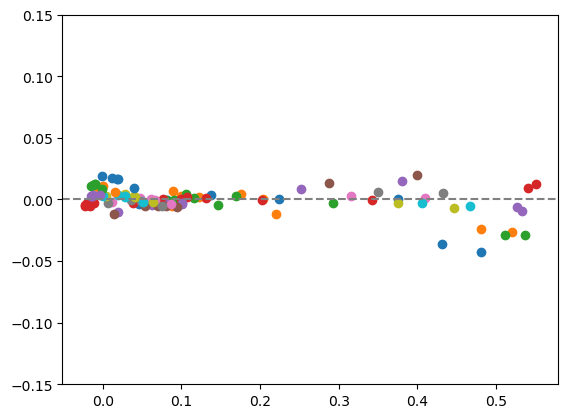

Average abs. residual:  0.006750809099783961


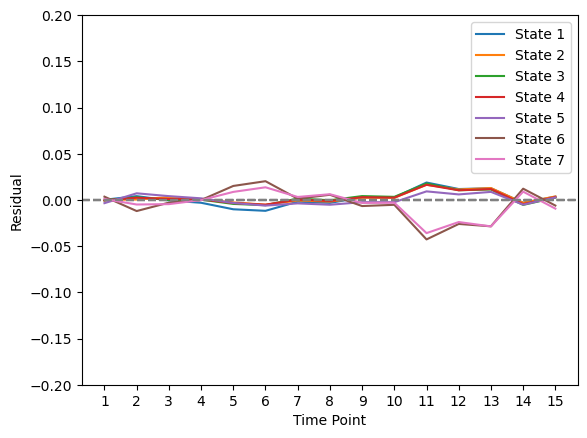

In [9]:
# residuals
new = closedNoise_theta
S1_Q = theta_to_Q(new, k)

state_list = ['State ' + str(i) for i in range(1,k+1)]

epsi = np.zeros((T-1,k))
pred = np.zeros((k,T))

for i in range(1,T):
    S1_P = transMat(S1_Q, u[i-1])
    pred[:,(i-1)] = np.matmul(S1_P.transpose(),N[:,(i-1)]) 
    epsi[(i-1),:] = pred[:,(i-1)] - N[:,i]
    plt.scatter(pred[:,(i-1)], epsi[(i-1),:])

plt.axhline(y=0, linestyle = '--', color = 'grey')
plt.ylim(-.15,.15)
plt.show() 

xseq = []
for i in range(1,timeCourse): xseq.append(str(i))

for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = state_list[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.axhline(y=0, linestyle = '--', color = 'grey')

plt.ylim(-.2,.2)
        
print("Average abs. residual: ", np.mean(abs(epsi)))

In [10]:
pd.DataFrame(transMat(S1_Q, u[0]), index=state_list, columns=state_list)

,State 1,State 2,State 3,State 4,State 5,State 6,State 7
State 1,0.469788,0.099505,0.099799,0.104313,0.043175,0.159755,0.023664
State 2,0.000000,0.744294,0.000026,0.053466,0.054704,0.049260,0.098249
State 3,0.000000,0.000000,0.759089,0.182888,0.047279,0.005295,0.005449
State 4,0.000000,0.000000,0.000000,0.576316,0.309480,0.056216,0.057988
State 5,0.000000,0.000000,0.000000,0.000000,0.547074,0.222435,0.230491
State 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.987482,0.012518
State 7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
# transform residual vector
Y = np.array([])
X = np.empty((0,2))

for t in range(T-1):
    Y = np.append(Y,epsi[t,:], axis=0)
    time = [t+1]*len(state_list)
    features = np.concatenate((np.array(time).reshape(7,1),np.array(state_list).reshape(7,1)), axis = 1)
    X = np.append(X,features, axis = 0)

df=pd.DataFrame(X, columns=('TimePoint','State'))
df.TimePoint = df.TimePoint.astype('int64')
df = pd.get_dummies(data=df, drop_first=True)
X = df


In [12]:
import statsmodels.api as sm
X = sm.add_constant(X)
X = X.astype('float')
ls=sm.OLS(Y,X).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.433
Date:                Thu, 13 Jun 2024   Prob (F-statistic):              0.201
Time:                        20:17:46   Log-Likelihood:                 337.47
No. Observations:                 105   AIC:                            -658.9
Df Residuals:                      97   BIC:                            -637.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.003      0.477

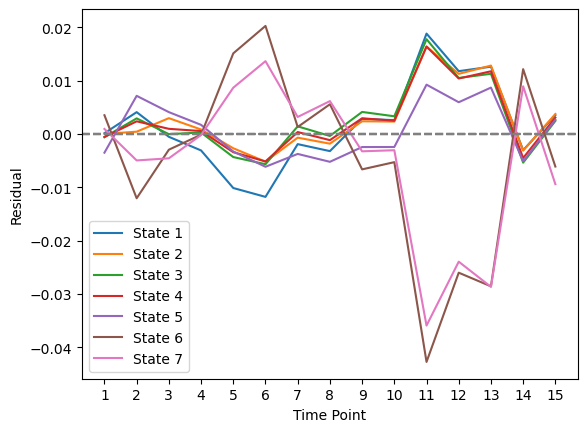

In [13]:
for i in range(epsi.shape[1]): plt.plot(xseq,epsi[:,i], label = state_list[i]); plt.legend(); plt.xlabel("Time Point"); plt.ylabel("Residual"); plt.axhline(y=0, linestyle = '--', color = 'grey')


### Error Estimation

We want to take bootstrap samples with replacement of the same size as the original. Then we will run our estimator, this will be repeated $B$ times. The estimate standard error will be: 

\begin{equation}
    \hat{se}_B = \sqrt{\frac{\sum_{b=1}^B \hat{\theta}(b) - \hat{\theta}^*}{B-1}}
\end{equation}

where $\hat{\theta}^* = \frac{\sum_{b=1}^B \hat{\theta}(b)}{B}$.

In [14]:
# number of bootstrap samples
B = 500

stateParam = {'state_col_name': 'State', 'numStates': k}
timeParam = {'timemarker': 'd', 'dayColumnName': 'Day', 'timeinterval': u}
mcArgs = {'mciter': mc_iter, 'n_cores': numCores}
optimiserArgs = {'costFunc': calc_S1, 'bounds': reg_bounds, 'constraints': reg_con, 'sampRange_ub': sampRange_ub} 
options = {'xterm': xterm, 'max_iter': max_iter}

#### NP: Case Resample

In [15]:
sim_repertoire = pd.DataFrame({'State': [], 'Day': []})

for i in range(simCN_df.shape[1]):
    day = simCN_df.columns[i]
    
    day_count = simCN_df[day]
    
    day_rep = pd.DataFrame({'State': [], 'Day': []})
    
    for j in range(7):
        state_rep = pd.DataFrame({'State':['State ' + str(j+1)], 'Day': day})
        day_rep = day_rep._append(int(day_count[j]) * [state_rep])
    
    sim_repertoire = pd.concat([sim_repertoire,day_rep])

In [16]:
caseResamp = bootstrap_caseResamp(sim_repertoire, B, timeParam, n_param, make_theta0, stateParam, state_list, mcArgs, optimiserArgs, options)
caseResamp['theta_est'] = closedNoise_theta

/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv


Compiling results...


In [17]:
import pickle 
# pickling
filename = "manuscript_results/simData_closedNoise_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp], f)

#### Resample residuals

In [18]:
residResamp = bootstrap_resResamp(simCN, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

Point estimate calculation ...


Optimisation progress:  [================================================] 100%
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
 

Compiling results...


In [19]:
# pickling
filename = "manuscript_results/simData_closedNoise_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp,residResamp], f)

### Parametric

In [20]:
parametric = bootstrap_parametric(simCN, u, B, n_param, make_theta0, mcArgs, optimiserArgs, options)

Point estimate calculation ...


Optimisation progress:  [================================================] 100%
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
  P_l = A @ exp_D @ A_inv
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:407: RuntimeWarning: overflow encountered in exp
  exp_dt = np.exp(d*u_l)
/home/lservius/Documents/Computation/Y3/script/csr-path/mm_functions_optSim.py:411: RuntimeWarning: invalid value encountered in matmul
 

Compiling results...


In [21]:
# pickling
filename = "manuscript_results/simData_closedNoise_bootstrap.pkl"
with open(filename, 'wb') as f:
    pickle.dump([caseResamp,residResamp, parametric], f)

Visualise Error

In [22]:
# pickling
filename = "manuscript_results/simData_closedNoise_bootstrap.pkl"
with open(filename, 'rb') as f:
    caseResamp,residResamp, parametric = pickle.load(f)

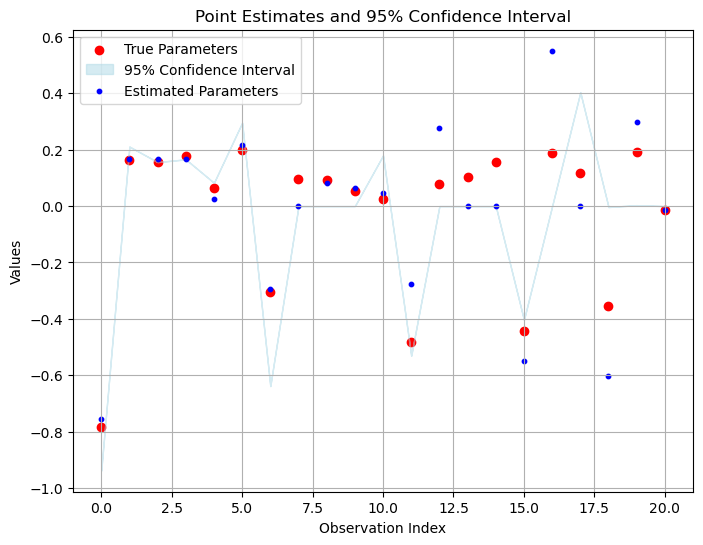

In [23]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(caseResamp['theta_est'])), y1=caseResamp['confidenceInterval'][0], y2=caseResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=caseResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

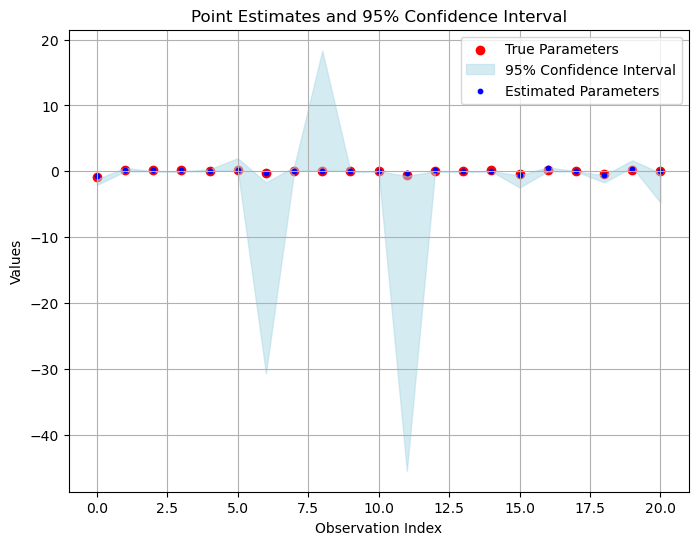

In [24]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(residResamp['theta_est'])), y1=residResamp['confidenceInterval'][0], y2=residResamp['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=residResamp['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

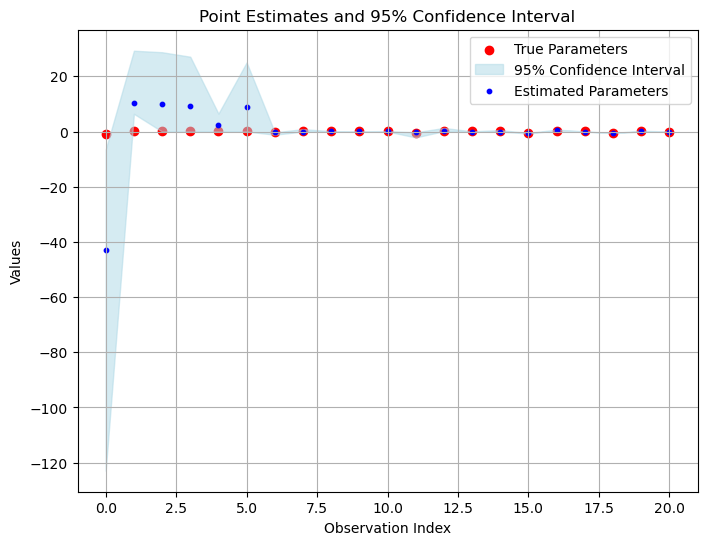

TypeError: theta_to_Q() missing 1 required positional argument: 'n_states'

<Figure size 800x600 with 0 Axes>

In [25]:
# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
plt.scatter(x=np.arange(n_param),y=Q_true[np.nonzero(Q_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(parametric['theta_est'])), y1=parametric['confidenceInterval'][0], y2=parametric['confidenceInterval'][1], color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=parametric['theta_est'], color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

### P error ###

# Create a plot
plt.figure(figsize=(8, 6))

# Plot the  true values
P_true = transMat(Q_true, 1)
P_est = theta_to_Q(parametric['theta_est'])
p_est = P_est[np.nonzero(P_est[:,:-1])]
p_CIlow = theta_to_Q(parametric['confidenceInterval'][0])[np.nonzero(P_est[:,:-1])]
p_CIhigh = theta_to_Q(parametric['confidenceInterval'][1])[np.nonzero(P_est[:,:-1])]


plt.scatter(x=np.arange(n_param),y=P_true[np.nonzero(P_true[:,:-1])], color='red', label='True Parameters')

# Plot the 95% confidence interval
plt.fill_between(x=np.arange(len(p_est)), y1=p_CIlow, y2=p_CIhigh, color='lightblue', alpha=0.5, label='95% Confidence Interval')

# Plot the data points
plt.scatter(x=np.arange(n_param), y=p_est, color='blue', label='Estimated Parameters', s = 10)

# Customize the plot
plt.title('Point Prob. Estimates and 95% Confidence Interval')
plt.xlabel('Observation Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Optional: add grid lines
plt.show()

### Number of Bootstrap Samples

In [1]:
# pickling
import pickle
filename = "manuscript_results/simData_closedNoise_bootstrap.pkl"
with open(filename, 'rb') as f:
    caseResamp,residResamp, parametric = pickle.load(f)

/home/lservius/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lservius/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


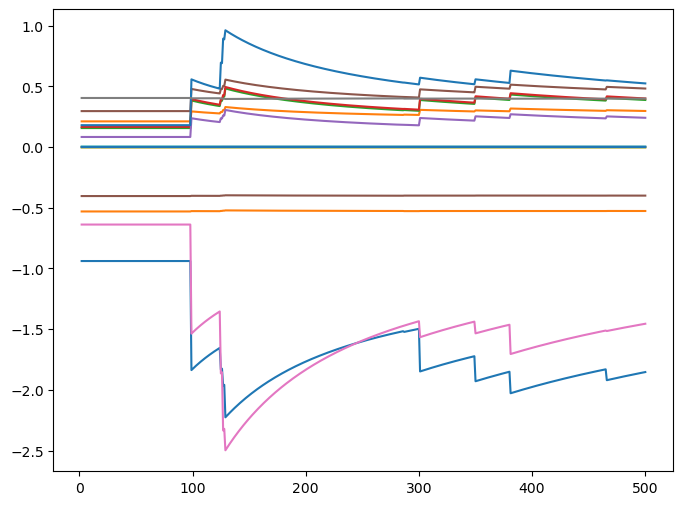

In [50]:
N_boot = len(caseResamp['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = caseResamp['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()

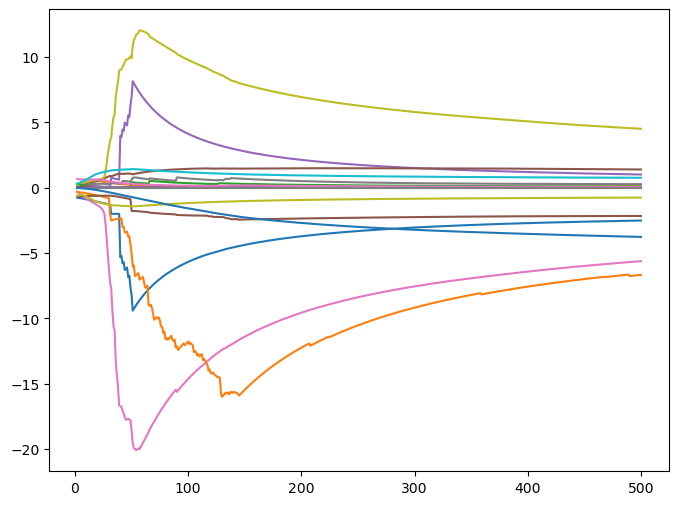

In [51]:
N_boot = len(residResamp['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = residResamp['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()

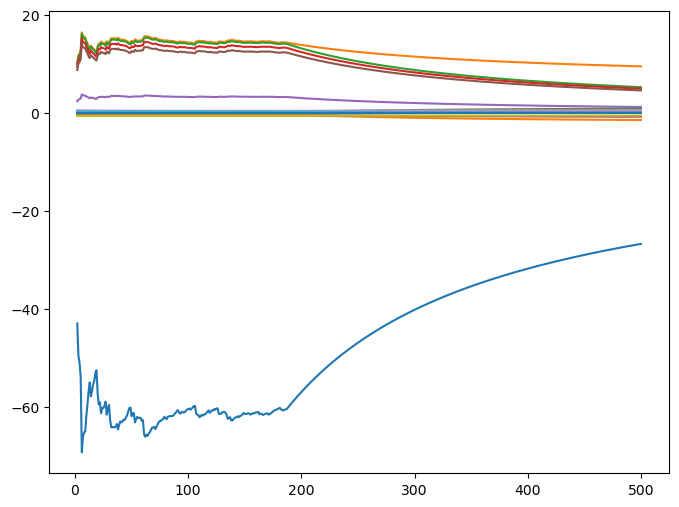

In [52]:
N_boot = len(parametric['bootEstimates'])

# Create a plot
plt.figure(figsize=(8, 6))

# x-axis
xaxis = np.linspace(1, N_boot, N_boot)
for p in range(n_param):
    param_boot = np.zeros(N_boot)
    mean_boot = np.zeros(N_boot)
    for b in range(N_boot):
        param_boot[b] = parametric['bootEstimates'][b][p]
        mean_boot[b] = np.mean(param_boot[:b])
    plt.plot(xaxis,mean_boot)
plt.show()